In [1]:
# Install dependencies not installed in Colab
%%capture
!pip install fbprophet

In [2]:
from google.colab import drive
import pandas as pd
import random
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from datetime import datetime

In [3]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


### Explanatory Data Analysis

In [4]:
# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)

In [5]:
# Load the train and test datasets
train_df = pd.read_csv('/content/drive/MyDrive/ML Assignment/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/ML Assignment/test.csv')

<ipython-input-5-63a752beffbe>:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('/content/drive/MyDrive/ML Assignment/train.csv')


In [6]:
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [7]:
train_df.shape

(1017209, 9)

In [8]:
# Print info to verify columns are loaded correctly
print("Train DataFrame Info:")
print(train_df.info())
print("\nTest DataFrame Info:")
print(test_df.info())

Train DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB
None

Test DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             41088 non-null  int64  
 1   Store          41088 non-null  int64  
 2   DayO

## NOTE
##### We can see that the 'Open' colomn in the test dataframe contains 11 null containing rows
##### We need to address this when making predictions

In [9]:
print("Train DataFrame Summary:")
print(train_df.describe())
print("\nTest DataFrame Summary:")
print(test_df.describe())

Train DataFrame Summary:
              Store     DayOfWeek         Sales     Customers          Open  \
count  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06   
mean   5.584297e+02  3.998341e+00  5.773819e+03  6.331459e+02  8.301067e-01   
std    3.219087e+02  1.997391e+00  3.849926e+03  4.644117e+02  3.755392e-01   
min    1.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    2.800000e+02  2.000000e+00  3.727000e+03  4.050000e+02  1.000000e+00   
50%    5.580000e+02  4.000000e+00  5.744000e+03  6.090000e+02  1.000000e+00   
75%    8.380000e+02  6.000000e+00  7.856000e+03  8.370000e+02  1.000000e+00   
max    1.115000e+03  7.000000e+00  4.155100e+04  7.388000e+03  1.000000e+00   

              Promo  SchoolHoliday  
count  1.017209e+06   1.017209e+06  
mean   3.815145e-01   1.786467e-01  
std    4.857586e-01   3.830564e-01  
min    0.000000e+00   0.000000e+00  
25%    0.000000e+00   0.000000e+00  
50%    0.000000e+00   0.000000e+00  
75% 

In [10]:
unique_counts = train_df.nunique().reset_index()
unique_counts.columns = ['Column', 'Unique Values']
print(unique_counts)

          Column  Unique Values
0          Store           1115
1      DayOfWeek              7
2           Date            942
3          Sales          21734
4      Customers           4086
5           Open              2
6          Promo              2
7   StateHoliday              5
8  SchoolHoliday              2


In [11]:
unique_counts = test_df.nunique().reset_index()
unique_counts.columns = ['Column', 'Unique Values']
print(unique_counts)

          Column  Unique Values
0             Id          41088
1          Store            856
2      DayOfWeek              7
3           Date             48
4           Open              2
5          Promo              2
6   StateHoliday              2
7  SchoolHoliday              2


In [12]:
print(train_df['StateHoliday'].unique())

['0' 'a' 'b' 'c' 0]


In [13]:
print(train_df['StateHoliday'].value_counts())

StateHoliday
0    855087
0    131072
a     20260
b      6690
c      4100
Name: count, dtype: int64


In [14]:
print(test_df['StateHoliday'].unique())

['0' 'a']


### NOTE
##### State Holiday contains variety of elements when it actually must only contain '0' or '1' in order to use as y target numeric regressor for prophet
##### This train dataset detects '0' twice because the data contains string and integer '0', this must be cleaned and prepared for the model correctly
##### ASSUMPTION : all state holiday variations are considered as 1 for simplicity

In [15]:
train_df['StateHoliday'] = (~train_df['StateHoliday'].astype(str).str.contains('0')).astype(int)

In [16]:
print(train_df['StateHoliday'].value_counts())

StateHoliday
0    986159
1     31050
Name: count, dtype: int64


In [17]:
test_df['StateHoliday'] = (~test_df['StateHoliday'].astype(str).str.contains('0')).astype(int)

In [18]:
print(test_df['StateHoliday'].value_counts())

StateHoliday
0    40908
1      180
Name: count, dtype: int64


#### Since Sales and Customers contains large variety of numbers its best to plot and visualize the distribution

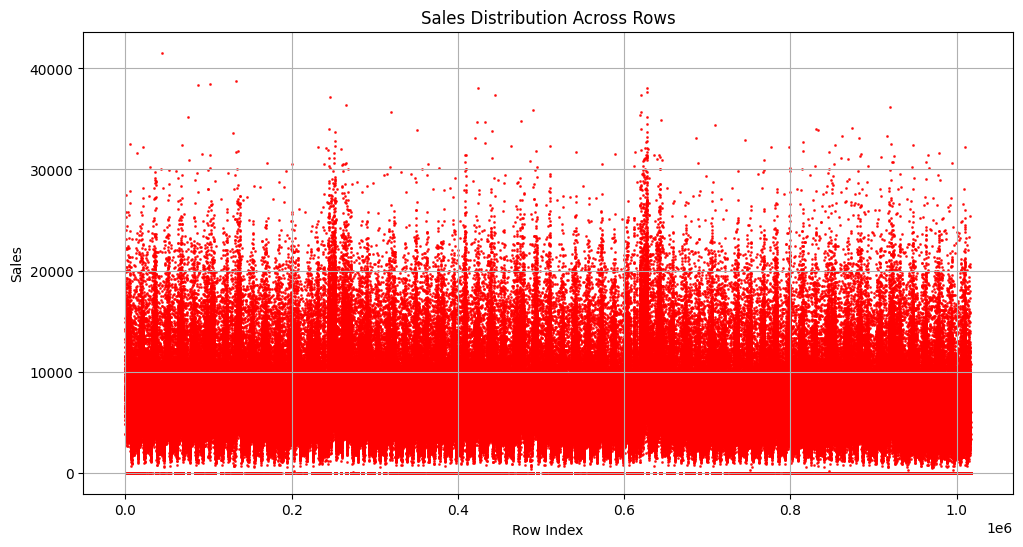

In [19]:
plt.figure(figsize=(12, 6))
plt.scatter(train_df.index, train_df['Sales'], s=1, color='red', alpha=0.8)
plt.title('Sales Distribution Across Rows')
plt.xlabel('Row Index')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

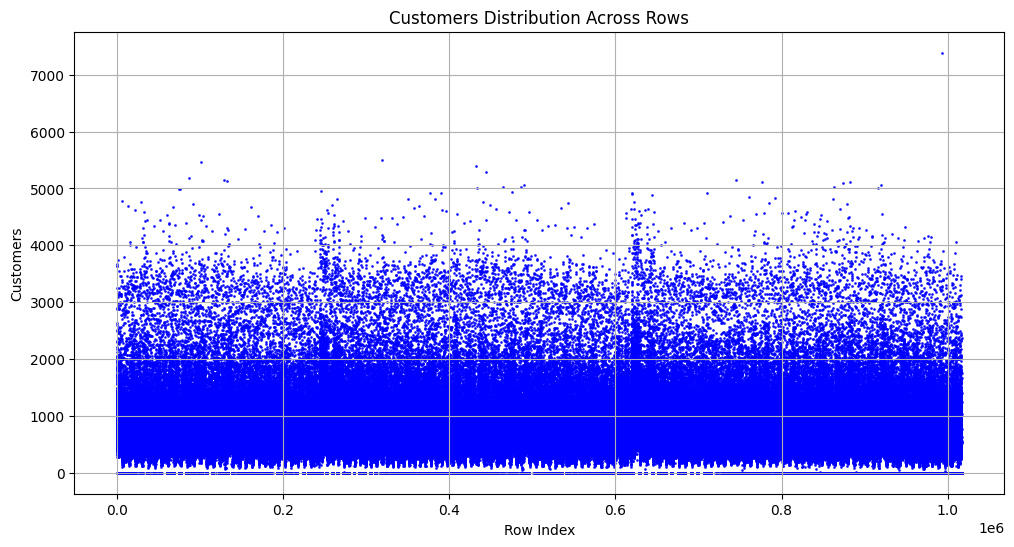

In [20]:
plt.figure(figsize=(12, 6))
plt.scatter(train_df.index, train_df['Customers'], s=1, color='blue', alpha=0.8)
plt.title('Customers Distribution Across Rows')
plt.xlabel('Row Index')
plt.ylabel('Customers')
plt.grid(True)
plt.show()

#### The Visuals show how none of the colomns contain negative values
#### However we still need to check for outliers
#### There consist no negative values for both distributions so upper bound outliers are only considered

In [21]:
threshold = 4
# Calculate Inter-Quartile Range(IQR)
Q1 = train_df['Sales'].quantile(0.25)
Q3 = train_df['Sales'].quantile(0.75)
IQR = Q3 - Q1

# Define upper bound (adjust threshold based on severity)
upper_bound = Q3 + 1.5 * IQR*threshold
train_df['Sales'] = train_df['Sales'].clip(upper=upper_bound)

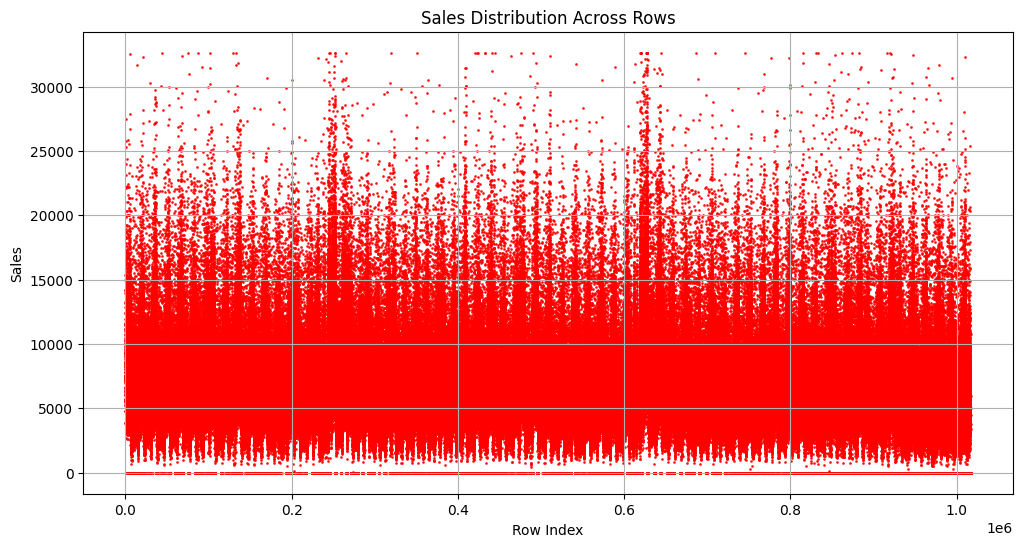

In [22]:
plt.figure(figsize=(12, 6))
plt.scatter(train_df.index, train_df['Sales'], s=1, color='red', alpha=0.8)
plt.title('Sales Distribution Across Rows')
plt.xlabel('Row Index')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

In [23]:
threshold = 6
# Calculate Inter-Quartile Range(IQR)
Q1 = train_df['Customers'].quantile(0.25)
Q3 = train_df['Customers'].quantile(0.75)
IQR = Q3 - Q1

# Define upper bound (adjust threshold based on severity)
upper_bound = Q3 + 1.5 * IQR*threshold
train_df['Customers'] = train_df['Customers'].clip(upper=upper_bound)

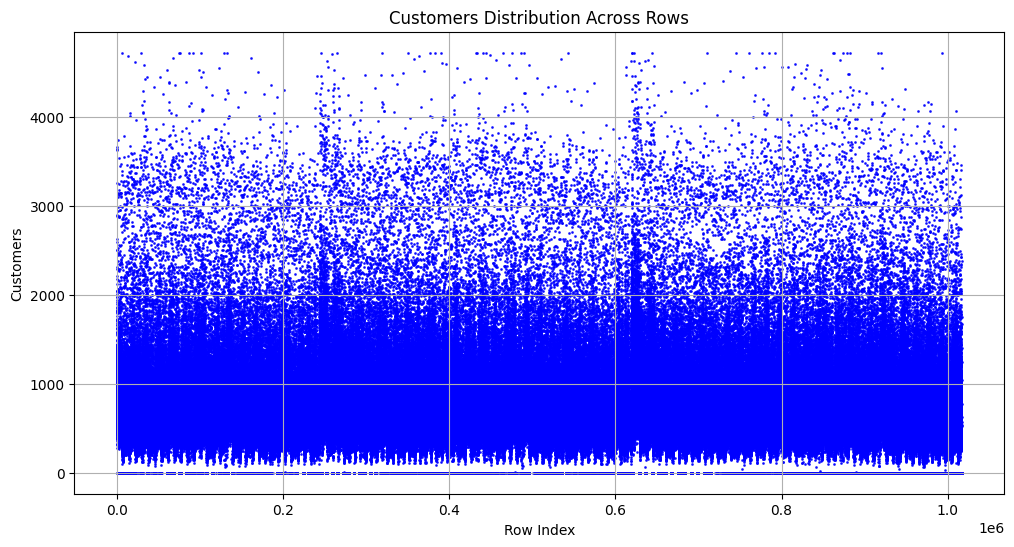

In [24]:
plt.figure(figsize=(12, 6))
plt.scatter(train_df.index, train_df['Customers'], s=1, color='blue', alpha=0.8)
plt.title('Customers Distribution Across Rows')
plt.xlabel('Row Index')
plt.ylabel('Customers')
plt.grid(True)
plt.show()

#### Now the Distributions looks better where upper bound outliers are eliminated
#### Now we need to handle the null values in the 'Open' colomn in test dataframe

In [25]:
null_count = test_df['Open'].isnull().sum()
print(f"Null values in 'Open': {null_count}")

Null values in 'Open': 11


In [26]:
# Replace 'null' with '0'
test_df['Open'] = test_df['Open'].fillna(0).astype(int)

In [27]:
null_count = test_df['Open'].isnull().sum()
print(f"Null values in 'Open': {null_count}")

Null values in 'Open': 0


#### Now we have successfully handled Null Values in the test dataframe
#### Next we need to convert Date colomns datatype into Date

In [28]:
# Convert the date column to datetime
# ds refers to datestamp here which is standard for Prophet
train_df['ds'] = pd.to_datetime(train_df['Date'], format='%Y-%m-%d')
test_df['ds'] = pd.to_datetime(test_df['Date'], format='%Y-%m-%d')

In [29]:
# Verify the conversion train dataframe
print(train_df['ds'].dtype)  # Should output: datetime64[ns]
print(train_df.head())

datetime64[ns]
   Store  DayOfWeek        Date  Sales  Customers  Open  Promo  StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1             0   
1      2          5  2015-07-31   6064        625     1      1             0   
2      3          5  2015-07-31   8314        821     1      1             0   
3      4          5  2015-07-31  13995       1498     1      1             0   
4      5          5  2015-07-31   4822        559     1      1             0   

   SchoolHoliday         ds  
0              1 2015-07-31  
1              1 2015-07-31  
2              1 2015-07-31  
3              1 2015-07-31  
4              1 2015-07-31  


In [30]:
# Verify the conversion for test dataframe
print(test_df['ds'].dtype)  # Should output: datetime64[ns]
print(test_df.head())

datetime64[ns]
   Id  Store  DayOfWeek        Date  Open  Promo  StateHoliday  SchoolHoliday  \
0   1      1          4  2015-09-17     1      1             0              0   
1   2      3          4  2015-09-17     1      1             0              0   
2   3      7          4  2015-09-17     1      1             0              0   
3   4      8          4  2015-09-17     1      1             0              0   
4   5      9          4  2015-09-17     1      1             0              0   

          ds  
0 2015-09-17  
1 2015-09-17  
2 2015-09-17  
3 2015-09-17  
4 2015-09-17  


#### CHECK for SALES and CUSTOMERS Logic
##### sales and customers must be zero when open == 0

In [31]:
# Find rows where store is closed but has sales/customers
invalid_sales = train_df[(train_df['Open'] == 0) & (train_df['Sales'] > 0)]
invalid_customers = train_df[(train_df['Open'] == 0) & (train_df['Customers'] > 0)]

print(f"Found {len(invalid_sales)} rows with sales when store was closed")
print(f"Found {len(invalid_customers)} rows with customers when store was closed")

Found 0 rows with sales when store was closed
Found 0 rows with customers when store was closed


In [32]:
# Print info to verify the final changes
print("Train DataFrame Info:")
print(train_df.info())
print("\nTest DataFrame Info:")
print(test_df.info())

Train DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 10 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  int64         
 2   Date           1017209 non-null  object        
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  int64         
 6   Promo          1017209 non-null  int64         
 7   StateHoliday   1017209 non-null  int64         
 8   SchoolHoliday  1017209 non-null  int64         
 9   ds             1017209 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(8), object(1)
memory usage: 77.6+ MB
None

Test DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 9 columns):
 #   Column         Non-

In [33]:
# Print Descriptions to verify the final changes
print("Train DataFrame Description:")
print(train_df.describe())
print("\nTest DataFrame Description:")
print(test_df.describe())

Train DataFrame Description:
              Store     DayOfWeek         Sales     Customers          Open  \
count  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06   
mean   5.584297e+02  3.998341e+00  5.773711e+03  6.331328e+02  8.301067e-01   
min    1.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    2.800000e+02  2.000000e+00  3.727000e+03  4.050000e+02  1.000000e+00   
50%    5.580000e+02  4.000000e+00  5.744000e+03  6.090000e+02  1.000000e+00   
75%    8.380000e+02  6.000000e+00  7.856000e+03  8.370000e+02  1.000000e+00   
max    1.115000e+03  7.000000e+00  3.263000e+04  4.725000e+03  1.000000e+00   
std    3.219087e+02  1.997391e+00  3.849115e+03  4.642840e+02  3.755392e-01   

              Promo  StateHoliday  SchoolHoliday  \
count  1.017209e+06  1.017209e+06   1.017209e+06   
mean   3.815145e-01  3.052470e-02   1.786467e-01   
min    0.000000e+00  0.000000e+00   0.000000e+00   
25%    0.000000e+00  0.000000e+00   0.000000e+00   

#### Sales Model

### XGBoost Approach

In [34]:
import xgboost as xgb

In [35]:
# Dictionary to hold models
sales_models = {}
customer_models = {}

In [36]:
def create_features(df):
    X = df[['DayOfWeek', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']].copy()
    dt = df['ds'].dt
    return X.assign(Month=dt.month, Day=dt.day, DayOfYear=dt.dayofyear)

In [37]:
def train_store_models(train_df, targets):
    models = {target: {} for target in targets}

    for store_id, store_data in train_df.groupby('Store'):
        if len(store_data) < 30:
            print(f"Skipping store {store_id} (insufficient data)")
            continue

        X = create_features(store_data)

        for target in targets:
            try:
                models[target][store_id] = xgb.XGBRegressor(
                    n_estimators=100, learning_rate=0.1, max_depth=5
                ).fit(X, store_data[target])
            except Exception as e:
                print(f"Error training {target} for store {store_id}: {str(e)}")

    return models

In [38]:
def predict_store_models(test_df, models):
    result = test_df.copy()

    for target, store_models in models.items():
        result[f'predicted_{target}'] = 0  # Initialize with zeros
        for store_id, model in store_models.items():
            mask = result['Store'] == store_id
            X_test = create_features(result[mask])
            result.loc[mask, f'predicted_{target}'] = model.predict(X_test).clip(0).round().astype(int)

    # Handle closed stores
    result.loc[result['Open'] == 0, ['predicted_Sales', 'predicted_Customers']] = 0
    return result

In [39]:
# Train models
models = train_store_models(train_df, ['Sales', 'Customers'])

# Generate predictions
result_df = predict_store_models(test_df, models)

# Save results
result_df.to_csv('/content/drive/MyDrive/ML Assignment/predicted_xgboost.csv', index=False)

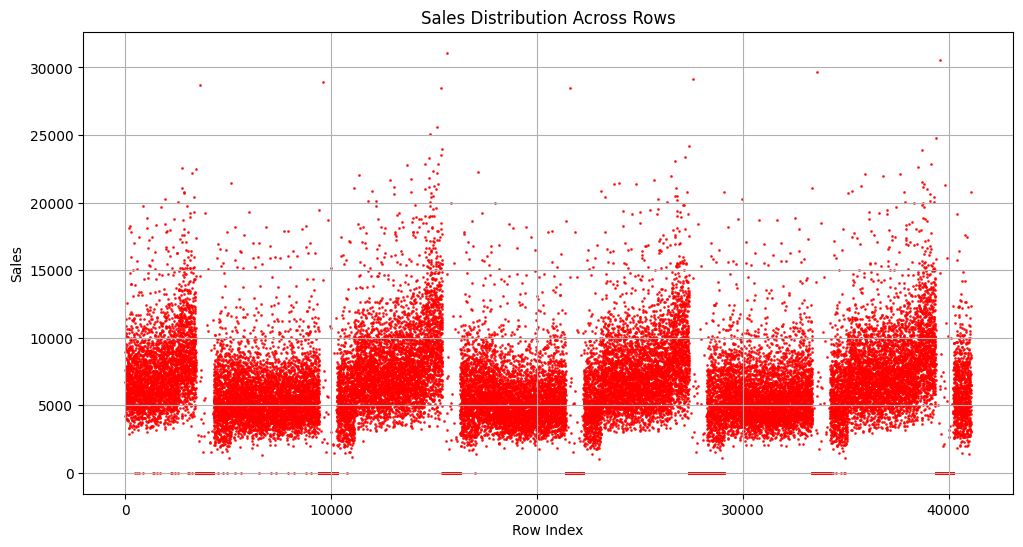

In [40]:
plt.figure(figsize=(12, 6))
plt.scatter(result_df.index, result_df['predicted_Sales'], s=1, color='red', alpha=0.8)
plt.title('Sales Distribution Across Rows')
plt.xlabel('Row Index')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

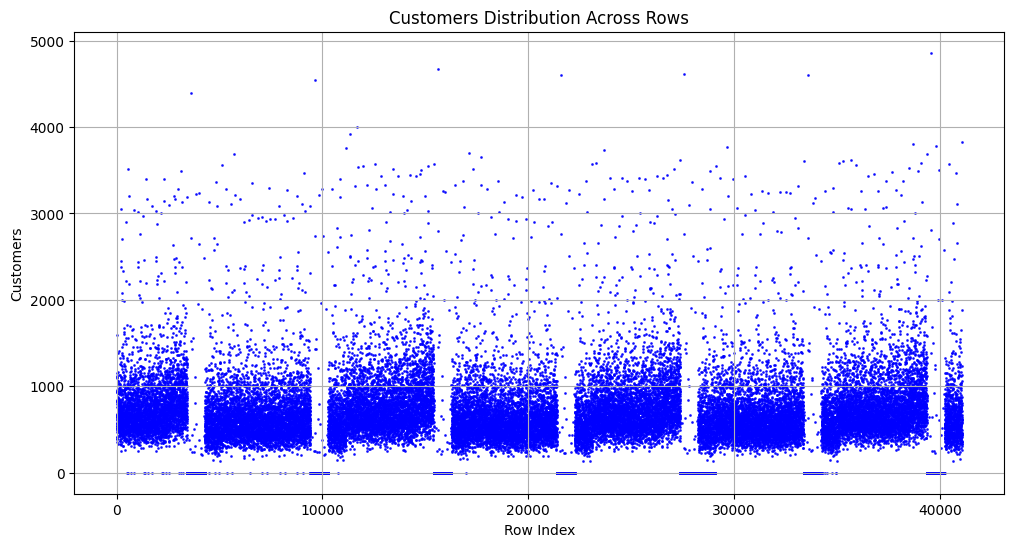

In [41]:
plt.figure(figsize=(12, 6))
plt.scatter(result_df.index, result_df['predicted_Customers'], s=1, color='blue', alpha=0.8)
plt.title('Customers Distribution Across Rows')
plt.xlabel('Row Index')
plt.ylabel('Customers')
plt.grid(True)
plt.show()